In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import h5py
import copy

import amici
from petab.C import *
import petab
import petab.C
import pypesto
import pypesto.petab
from pypesto.optimize import minimize
from pypesto.startpoint import uniform
from pypesto.engine import MultiProcessEngine, MultiThreadEngine
from pypesto.optimize.optimizer import FidesOptimizer
import pypesto.optimize as optimize

import pypesto
from pypesto.visualize import waterfall
from pypesto.visualize import parameters
from pypesto.visualize.model_fit import visualize_optimized_model_fit
from pypesto.visualize import profiles

import pypesto.profile as profile
from pypesto.optimize import ScipyOptimizer
from pypesto.profile.options import ProfileOptions

from pypesto.visualize.model_fit import visualize_optimized_model_fit, _get_simulation_rdatas

In [2]:
print(f"pypesto version: {pypesto.__version__}")
print(f"petab version: {petab.__version__}")
print(f"amici version: {amici.__version__}")

pypesto version: 0.5.3
petab version: 0.4.1
amici version: 0.26.1


In [3]:
# Plot setting
plt.rcParams['font.size'] = 30

dpi = 100
wid = int(2560/dpi)
hei = int(1600/dpi)

In [4]:
n_runs = 5000

In [5]:
# optimization
hierarchical = True

petab_yaml = 'petab_files/init_model.yaml'
petab.validate(petab_yaml)
petab_problem = petab.Problem.from_yaml(petab_yaml)

np.random.seed(500)

problem = pypesto.petab.PetabImporter(
        petab_problem,
        hierarchical=hierarchical,
        model_name=f"INIT_Model",
    ).create_problem(force_compile=True)

problem.objective.amici_model.setAllStatesNonNegative()

Compiling amici model to folder /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model.
2024-09-15 12:42:08.756 - amici.petab.sbml_import - INFO - Importing model ...
2024-09-15 12:42:08.757 - amici.petab.sbml_import - INFO - Validating PEtab problem ...
2024-09-15 12:42:08.766 - amici.petab.sbml_import - INFO - Model name is 'INIT_Model'.
Writing model code to '/Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model'.
2024-09-15 12:42:08.767 - amici.petab.sbml_import - INFO - Species: 0
2024-09-15 12:42:08.767 - amici.petab.sbml_import - INFO - Global parameters: 11
2024-09-15 12:42:08.768 - amici.petab.sbml_import - INFO - Reactions: 0
2024-09-15 12:42:08.778 - amici.petab.sbml_import - INFO - Observables: 1
2024-09-15 12:42:08.778 - amici.petab.sbml_import - INFO - Sigmas: 1
2024-09-15 12:42:08.779 - amici.petab.sbml_import - DEBUG - Adding output parameters to model: ['observableParameter1_tumor_vol', 'noiseParameter1_tumor_vol']
202

running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model -B /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model/build_model_ext -G Ninja -DCMAKE_MAKE_PROGRAM=/opt/homebrew/bin/ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model/INIT_Model -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/opt/homebrew/lib/python3.12/site-packages/amici/lib/cmake/SuiteSparse;/opt/homebrew/lib/python3.12/site-packages/amici/lib64/cmake/SuiteSparse -DKLU_ROOT=/opt/homebrew/lib/python3.12/site-packages/amici -DAMICI_PYTHON_BUILD_EXT_ONLY=ON -DPython3_EXECUTABLE=/opt/homebrew/opt/python@3.12/bin/python3.12

==> Building:
$ cmake --build /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model/build_m

2024-09-15 12:42:17.976 - amici.petab.sbml_import - INFO - Finished Importing PEtab model            (9.22E+00s)


In [6]:
result = pypesto.store.read_result('optimization_history/n'+ str(n_runs) +'.hdf5')

Loading the profiling result failed. It is highly likely that no profiling result exists within optimization_history/n5000.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within optimization_history/n5000.hdf5.


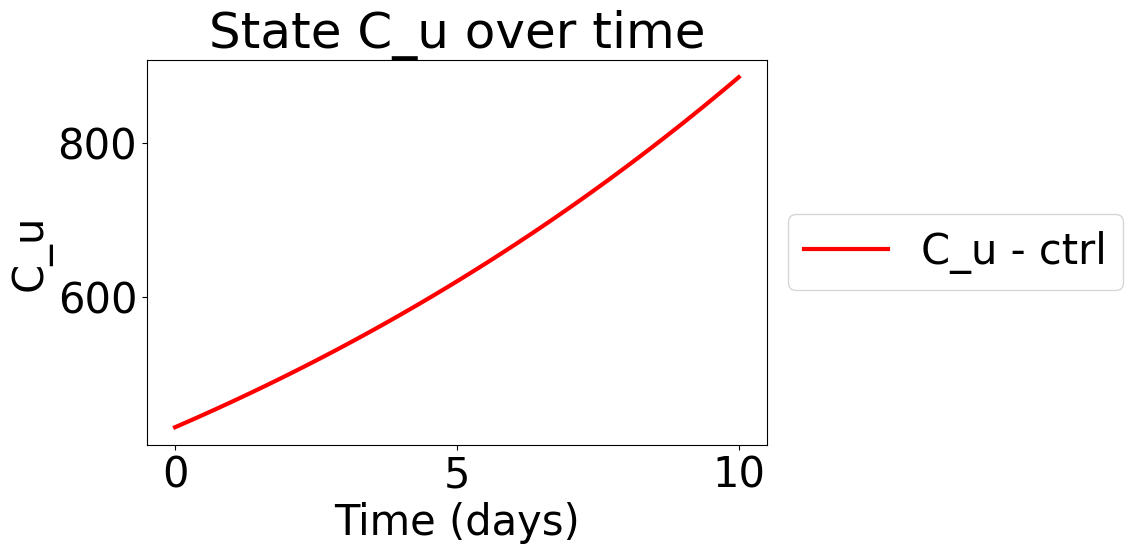

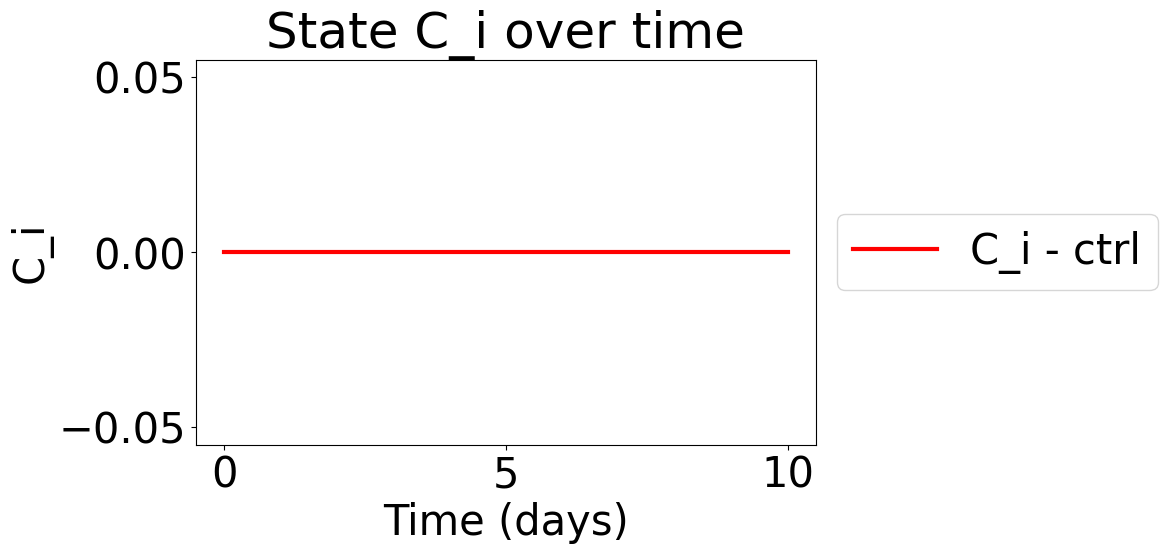

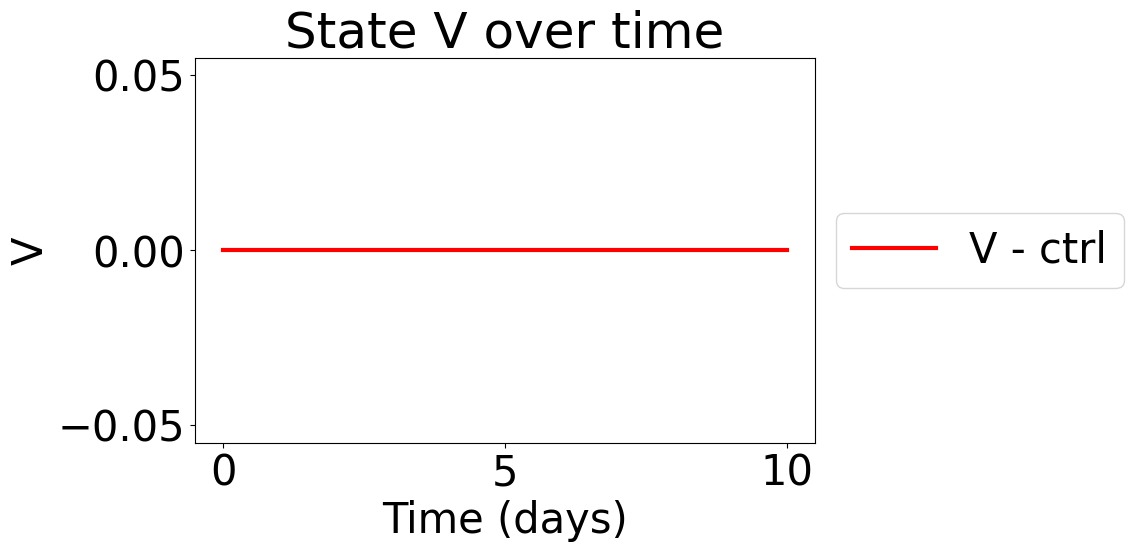

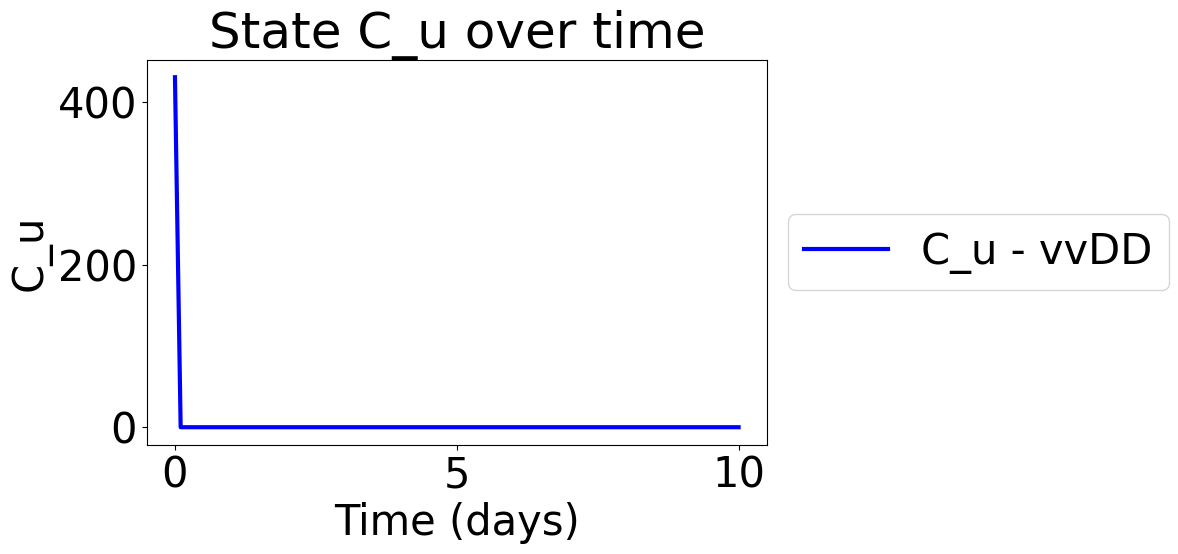

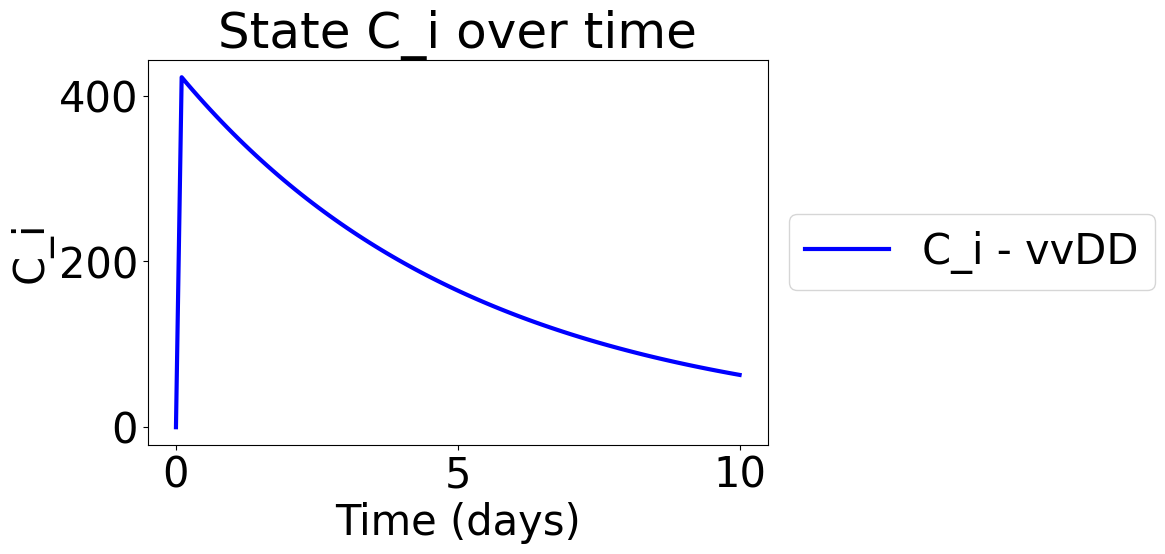

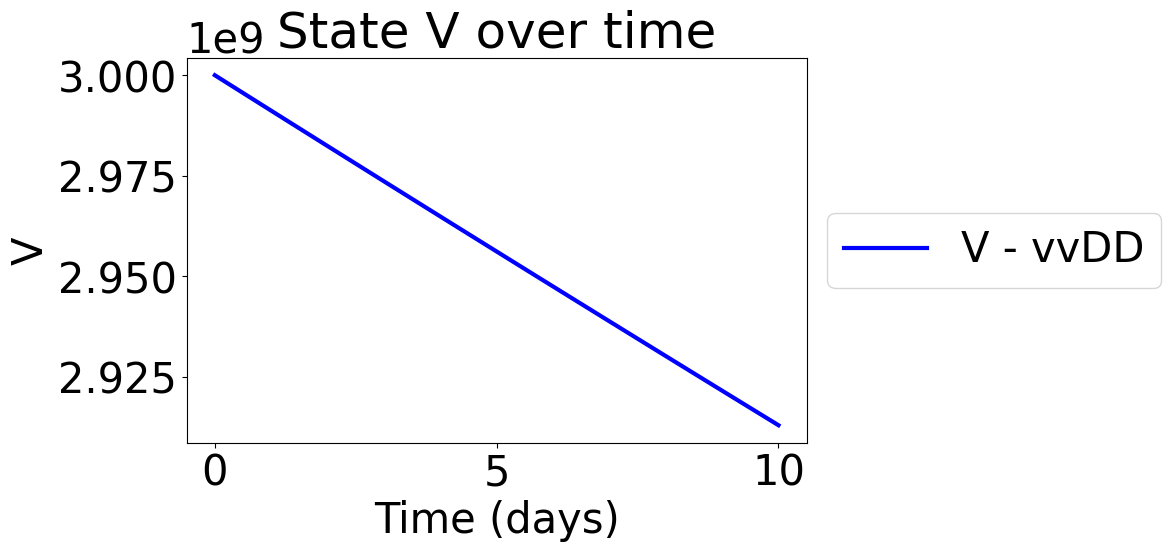

In [8]:
# visualize the temporal dynamics of the virus, uninfected and infected tumor cells using the fitted model from the result
# get the simulation results for the optimized parameters

amici_model = problem.objective.amici_model

species_to_plot = ['C_u', 'C_i', 'V']

# simulate from day 3 to day 12
timepoints = np.linspace(start=0, stop=10, num=100)

simulation_rdatas = _get_simulation_rdatas(
    result=result,
    problem=problem,
    start_index = 0,
    simulation_timepoints=timepoints,
)

# Plot all state trajectories
for c_ in range(len(problem.objective.edatas)):
    for species in species_to_plot:

        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        # for rdata, edata in zip(simulation_rdatas, problem.objective.edatas):
        label = f"{species} - {problem.objective.edatas[c_].id}"
        if problem.objective.edatas[c_].id == 'ctrl':
            ax.plot(timepoints, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='red', label=label, lw = 3)
        else:
            ax.plot(timepoints, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='blue', label=label, lw = 3)
        ax.set_ylabel(species)
        ax.set_xlabel('Time (days)')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"State {species} over time")
        plt.show()